## Federal Reserve Economic Data
#### Time Series Analysis with data showing the Natural Rate of Unemployment (long-term)

This notebook contains the time series analysis of the previous notebook plus a forecast.

In this notebook I want to explore time series analysis using data from https://data.nasdaq.com/data/FRED-federal-reserve-economic-data. I chose this data because it holds macroeconomic data which is related to the data of the Index of Economic Freedom that I was working with before. In a subset I excluded the forecasted data. Because the last update  - according to the website - was on February 1st, 2021, I take the value from 01-01-2021 as being the latest historic value and 01-01-1995 as the first historic value, because this is the beginning of the data range of the Index of Economic Freedom as well.

### Contents of this notebook
#### 01. Importing libraries and data
#### 02. Subsetting, wrangling and cleaning of data
#### 03. Decomposition of the data for time-series analysis
#### 04. Testing for stationarity
#### 05. Stationarizing the data
#### 06. Defining the parameters
#### 07. Splitting the data
#### 08. Running and fitting the model
#### 09 Iterating

### 01. Importing libraries and data

In [1]:
!pip install quandl

In [2]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# Configure API key 

quandl.ApiConfig.api_key = 'jfTczqKu817_qgizqpfP'

In [4]:
# Importing the Federal Reserve Economic Data "Natural Rate of Unemployment" variable.

data = quandl.get('FRED/NROU')

In [5]:
data.head()

,Value
Date,
1949-01-01,5.255053
1949-04-01,5.261516
1949-07-01,5.268013
1949-10-01,5.274564
1950-01-01,5.281182


In [6]:
data.shape

(332, 1)

In [7]:
data.columns

Index(['Value'], dtype='object')

In [8]:
type(data)

pandas.core.frame.DataFrame

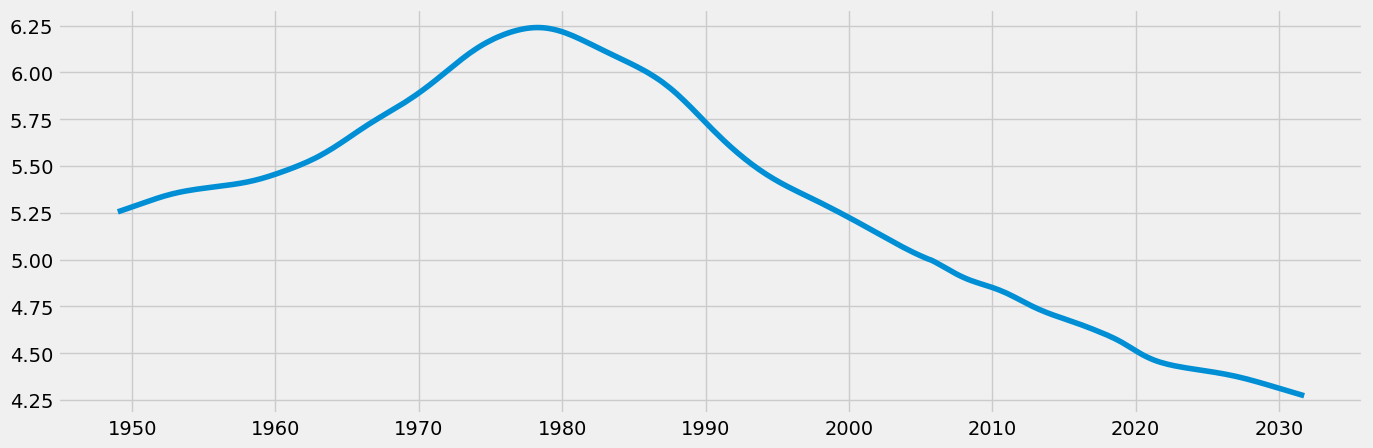

In [9]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) # The dpi argument controls the quality of the visualization here. When it's set to 100,
# it will produce lower-than-standard quality, which is useful if, similar to this notebook, you'll have a lot of plots.
# A large number of plots will increase the size of the notebook, which could take more time to load and eat up a lot of RAM!

plt.plot(data)

### 02. Subsetting, wrangling and cleaning of the data

In [10]:
# Resetting index so that you can use the "Date" column as a filter

data_2 = data.reset_index()

In [11]:
data_2.head()

,Date,Value
0,1949-01-01,5.255053
1,1949-04-01,5.261516
2,1949-07-01,5.268013
3,1949-10-01,5.274564
4,1950-01-01,5.281182


In [12]:
# Producing a subset for data from 1995 (data range of my primary data set) until February of 2021.
# It says on the website that the data has been refreshed on Feb. 1st, 2021. 
# The data also contains forecasted values until 2031 but I only use historic and not forecasted data.

data_sub = data_2.loc[(data_2['Date'] >= '1995-01-01') & (data_2['Date'] < '2021-02-01')]

In [13]:
data_sub.shape

(105, 2)

In [14]:
data_sub.head()

,Date,Value
184,1995-01-01,5.420172
185,1995-04-01,5.409451
186,1995-07-01,5.399091
187,1995-10-01,5.389050
188,1996-01-01,5.379276


In [15]:
data_sub.tail()

,Date,Value
284,2020-01-01,4.512876
285,2020-04-01,4.501435
286,2020-07-01,4.490658
287,2020-10-01,4.480756
288,2021-01-01,4.471833


Data is only listed for every three month so 01-01-2021 is the latest value for my chosen timeframe.

In [16]:
# Setting the "Date" column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date']) # Create a datetime column from "Date"
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
data_sub.head()

,Value
datetime,
1995-01-01,5.420172
1995-04-01,5.409451
1995-07-01,5.399091
1995-10-01,5.389050
1996-01-01,5.379276


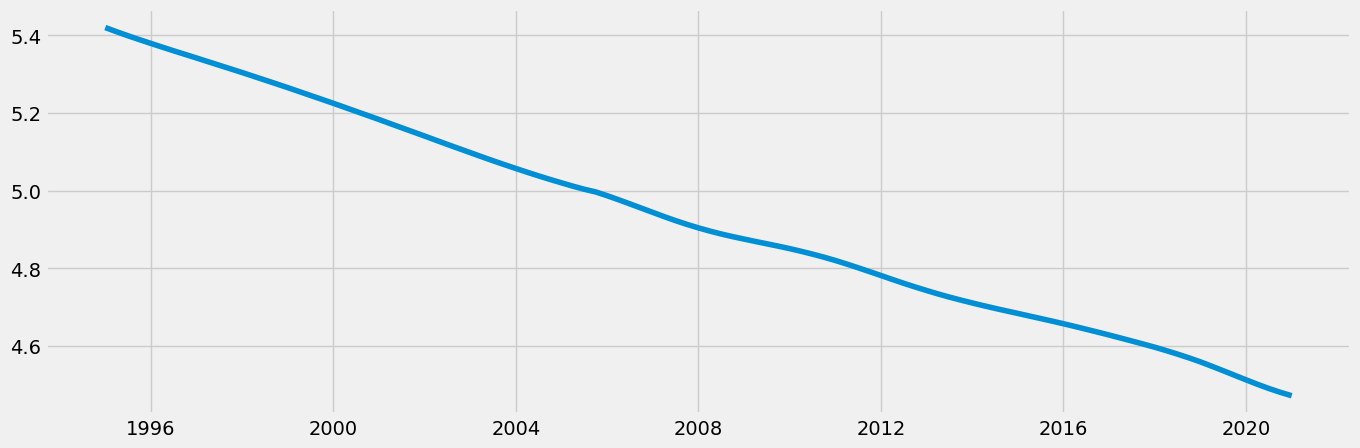

In [17]:
# Plotting the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

### 03. Decomposition of the data for time-series analysis

In [18]:
# Decomposing the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [19]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

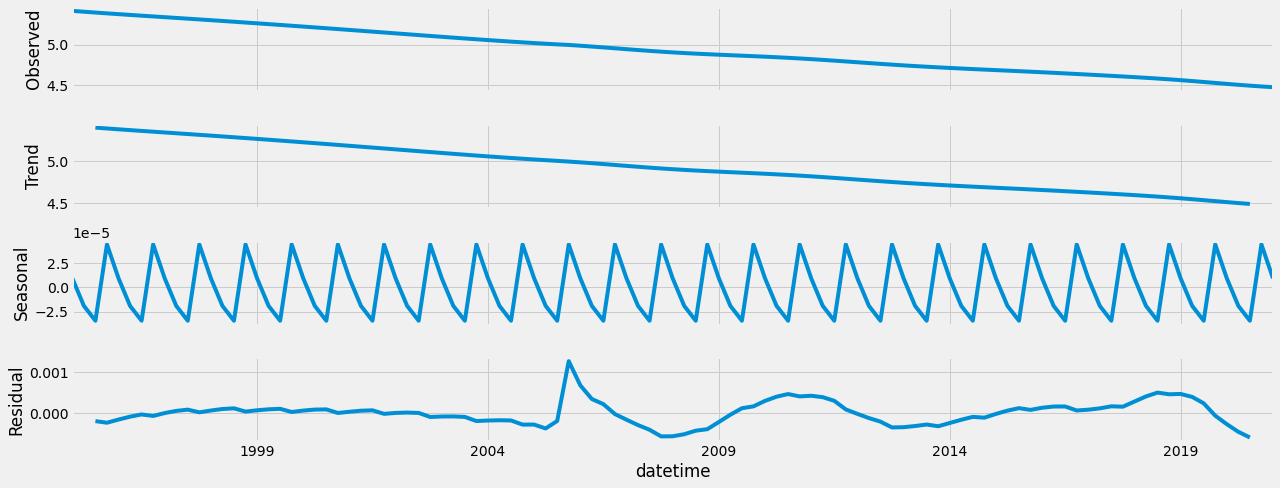

In [20]:
# Plotting the separate components

decomposition.plot()
plt.show()

The residual line is not continuous but as it only shows noise this doesn't need to be further investigated.

The level and trend appear the same because the data doesn't have much noise.

The seasonal line shows that the data has seasonality, which is not surprising with unemployment data, because there are seasonal jobs.

### 04. Testing for stationarity

In [21]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                  -2.448197
p-value                          0.128593
Number of Lags Used              4.000000
Number of Observations Used    100.000000
Critical Value (1%)             -3.497501
Critical Value (5%)             -2.890906
Critical Value (10%)            -2.582435
dtype: float64


In order to determine the results of a statistical hypothesis test, one has to compare the test statistic to the critical value of the corresponding significance level. If the test statistic is larger than the critical value, one can’t reject the null hypothesis. If the test statistic is smaller, then one can reject the null hypothesis. In this case, let’s say we are using a significance level of 5 percent. You’d need to look at the “Critical Value (5%)” in the results, which, here, has a value of -2.890906. This is smaller than the test statistic, which is -2.448197, which means that you can’t reject the null hypothesis.

What does this mean? That there is a unit root in your data, and the data is non-stationary. 

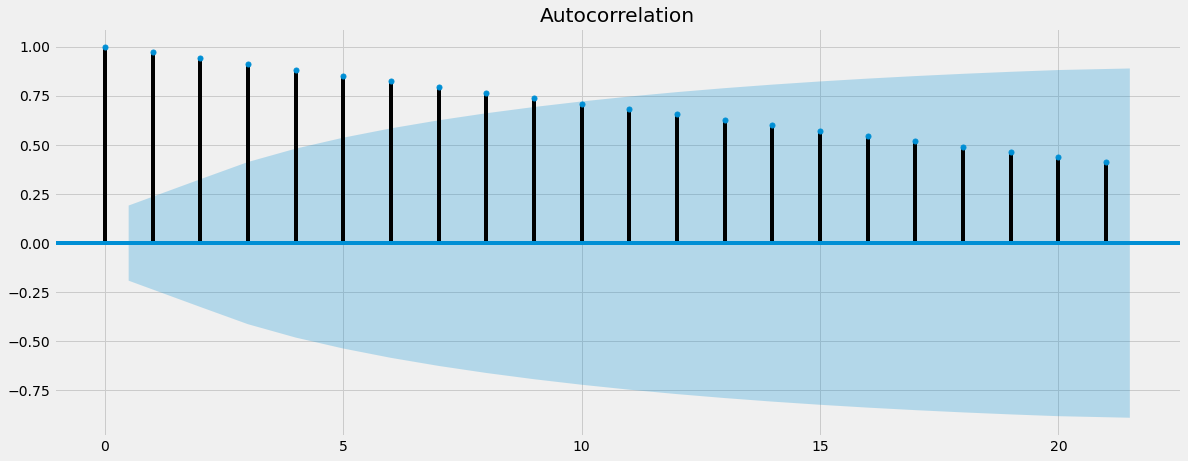

In [39]:
# Checking out autocorrelations with a plot

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_sub)
plt.show()

The vertical lines represent the lags in the series, while the blue area represents the confidence interval. When lines go above the blue edge of the confidence interval, this means there are lags that are significantly correlated with each other. Thus, it can be deduced that the data is non-stationary.

### 05. Stationarizing the data

In [23]:
data_diff = data_sub - data_sub.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole data t - (t -1)

In [24]:
data_diff.dropna(inplace = True) # Here, the missing values that came about as a result of the differencing are removed. 
# They need to be removed or the Dickey-Fuller test won't run.

In [25]:
data_diff.head()

,Value
datetime,
1995-04-01,-0.010721
1995-07-01,-0.010360
1995-10-01,-0.010041
1996-01-01,-0.009774
1996-04-01,-0.009567


In [26]:
data_diff.tail()

,Value
datetime,
2020-01-01,-0.011806
2020-04-01,-0.011441
2020-07-01,-0.010777
2020-10-01,-0.009902
2021-01-01,-0.008923


In [27]:
data_diff.columns

Index(['Value'], dtype='object')

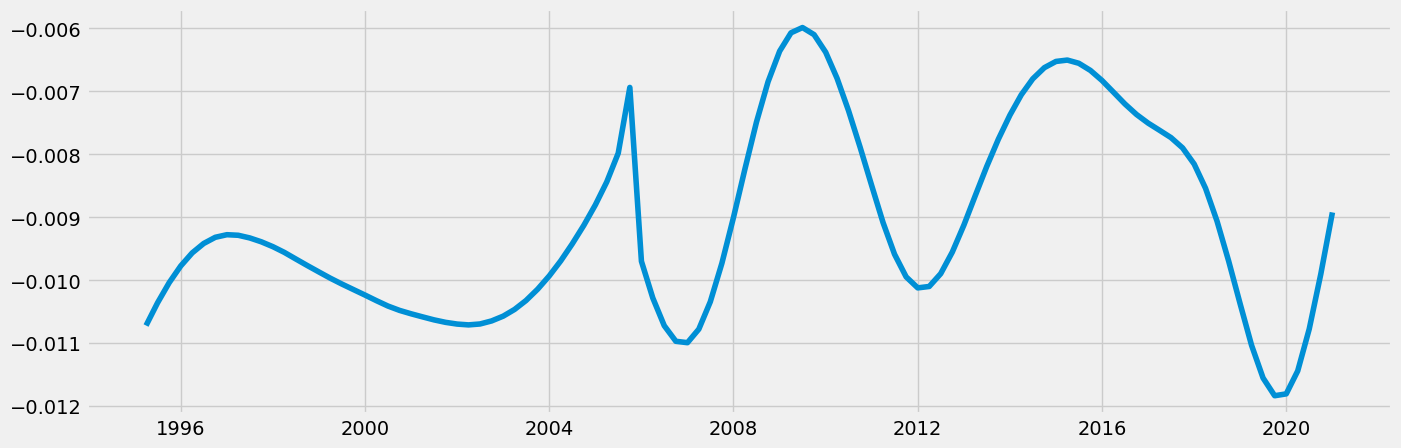

In [28]:
# Checking out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

The values on the y-axis have changed greatly. This is because, by stationarizing data, one effectively gets rid of the data’s trend. The trend is what gave the data its downward slope. Without it, there is a much more horizontal line and more visible patterns.

In [29]:
# Running the Dickey-Fuller-Test again

#dickey_fuller(data_diff)

As we have already said above, we are using a significance level of 5 percent. So we need to look at the “Critical Value (5%)” in the results, which, still, has a value of -2.890906. This is still smaller than the test statistic, which is now -3.931123, which means that we can’t reject the null hypothesis and the data is still non-stationary. 

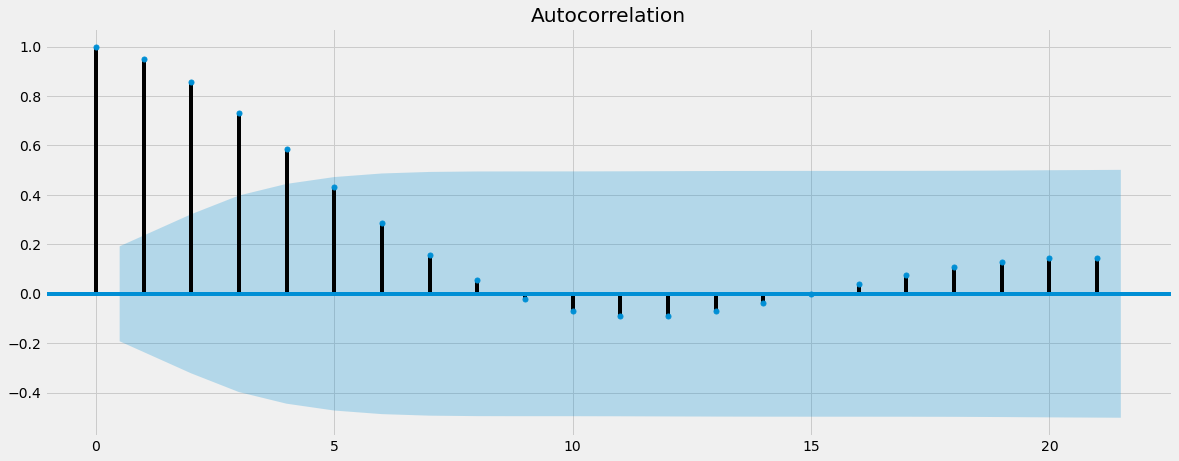

In [30]:
# Plotting the autocorrelation again

plot_acf(data_diff)
plt.show()

While the autocorrelation plot has improved (there are fewer autocorrelated terms), it’s still not perfect. This means that, despite the Dickey-Fuller showing an improvement, the data is still not stationary. One could conduct another round of differencing to stationarize it further and reduce the remaining autocorrelated terms. But, the unspoken rule of thumb is that one need at least ten significant lags (or ten vertical lines above the confidence interval) for a second round of differencing to be necessary. In this case there are only 5 vertical lines above the confidence interval, so I stop here.

### 06. Defining the parameters

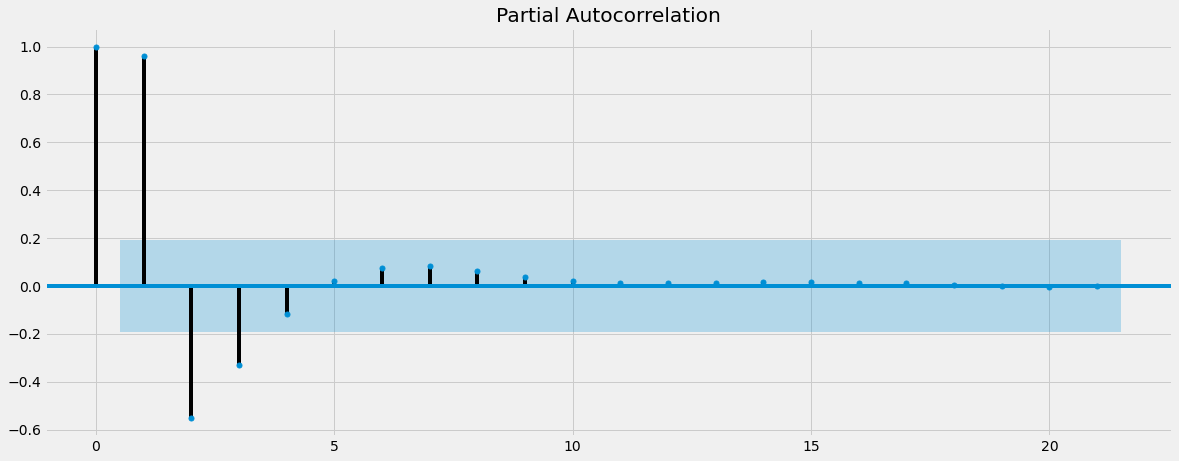

<Figure size 4500x4500 with 0 Axes>

In [31]:
# Plot partial autocorrelations to determine parameter p

plot_pacf(data_diff)
plt.figure(figsize=(15,15), dpi=300)
plt.show()

The figure above shows some highly positive bars. These indicate significant correlations. Let’s start by picking 5 AR terms to compensate for the highest of the partial autocorrelations. This makes p = 5.

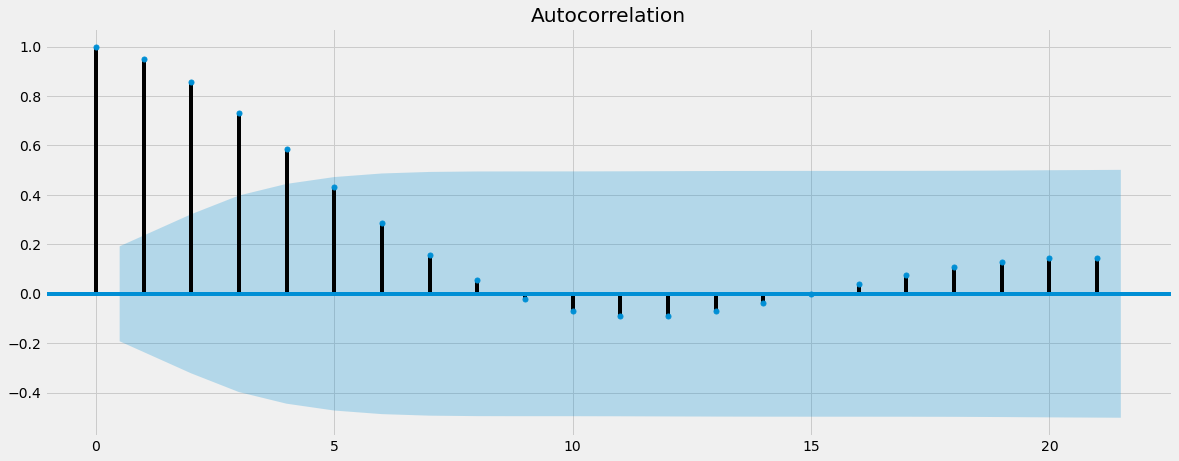

<Figure size 1500x500 with 0 Axes>

In [32]:
# Plot autocorrelations to determine parameter q

plot_acf(data_diff)
plt.figure(figsize=(15,5), dpi=100)
plt.show()

We have five significant autocorrelations here (those that run beyond the blue border), but for now, we take a more conservative approach and see what the output is like at q = 3. (It’s advisable to start with fewer terms as opposed to more and adjust accordingly further down the line as we begin testing the model.)

### 07. Splitting the data

In [33]:
# Checking how big data_diff is

data_diff.shape

(104, 1)

In [34]:
# Splitting the data, choosing 20 % of the data for the train data

train = data_diff['Value'][:81]
test = data_diff['Value'][80:]

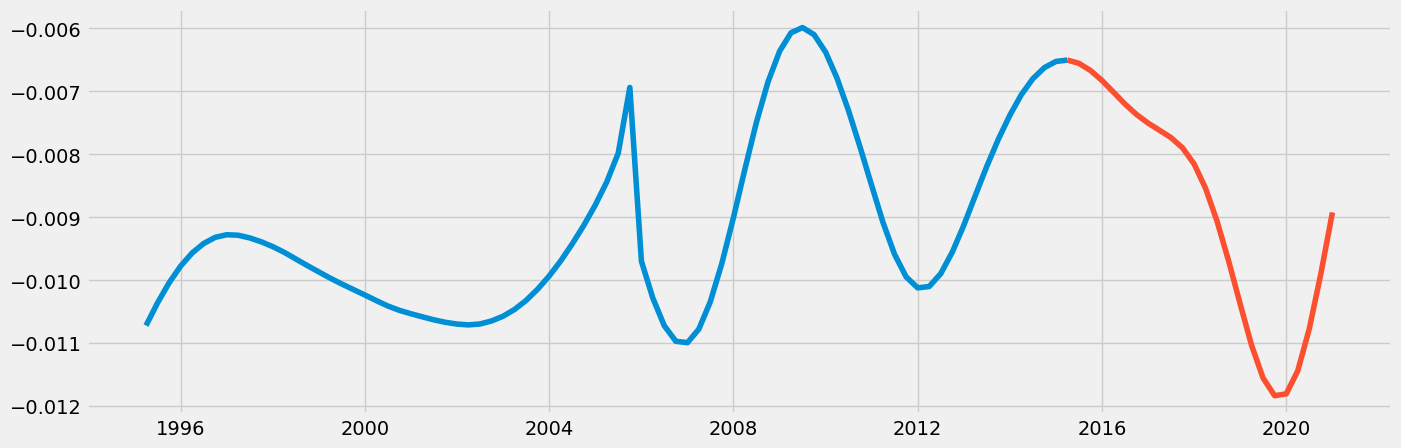

In [35]:
# Plotting both sets in order to see the split

plt.figure(figsize=(15,5), dpi=100)
plt.plot(train)
plt.plot(test)

In [36]:
test.shape

(24,)

### 08. Running and fitting the model

In [37]:
from statsmodels.tsa.api import ARIMA # Importing the best model for time series forecasting, ARIMA 

                             ARIMA Model Results                              
Dep. Variable:                D.Value   No. Observations:                   80
Model:                 ARIMA(5, 1, 3)   Log Likelihood                 516.693
Method:                       css-mle   S.D. of innovations              0.000
Date:                Mon, 09 May 2022   AIC                          -1013.386
Time:                        08:38:16   BIC                           -989.565
Sample:                    07-01-1995   HQIC                         -1003.835
                         - 04-01-2015                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          3.806e-05   1.14e-05      3.337      0.001    1.57e-05    6.04e-05
ar.L1.D.Value    -0.0830        nan        nan        nan         nan         nan
ar.L2.D.Value     0.9709      1.474     

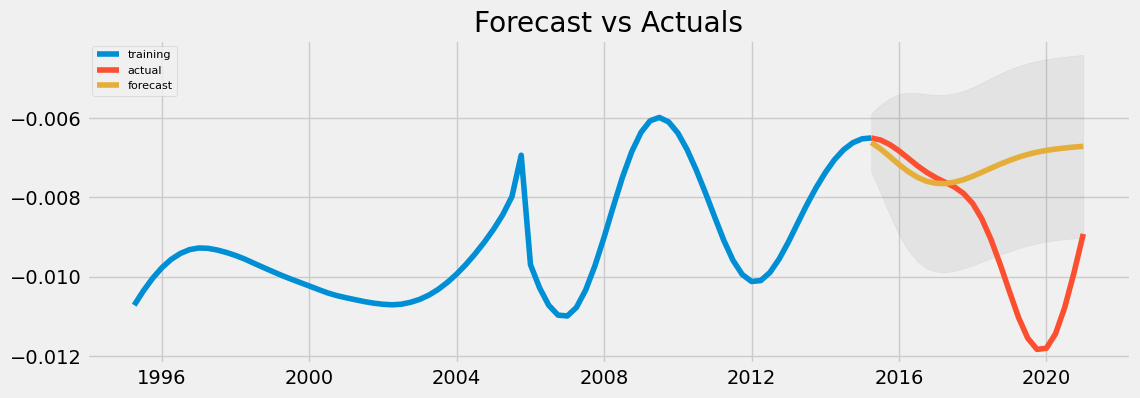

In [38]:
model = ARIMA(train, order=(5, 1, 3))  
fitted = model.fit()  
print(fitted.summary()) # Check model summary

# Forecast
fc, se, conf = fitted.forecast(24, alpha=0.05)  # 95% confidence interval  --> alpha = 0.05; 41 is the shape of the test set

# Make into pandas series
fc_series = pd.Series(fc, index=test.index) # This creates the forecasted curve
lower_series = pd.Series(conf[:, 0], index=test.index) # lower bound of the confidence interval
upper_series = pd.Series(conf[:, 1], index=test.index) # Upper bound of the confidence interval

# Plot
plt.figure(figsize=(12,4), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.05) # This creates the confidence interval
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

If the model is a good fit the forecast line should overlap with the actual line, which it doesn't. This means we have to make another iteration of the model.

### 09. Iterating

                             ARIMA Model Results                              
Dep. Variable:                D.Value   No. Observations:                   80
Model:                 ARIMA(3, 1, 1)   Log Likelihood                 510.607
Method:                       css-mle   S.D. of innovations              0.000
Date:                Mon, 09 May 2022   AIC                          -1009.214
Time:                        08:54:17   BIC                           -994.922
Sample:                    07-01-1995   HQIC                         -1003.484
                         - 04-01-2015                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           5.93e-05   9.91e-05      0.598      0.551      -0.000       0.000
ar.L1.D.Value     0.1894      1.106      0.171      0.864      -1.978       2.357
ar.L2.D.Value     0.2462      0.326     

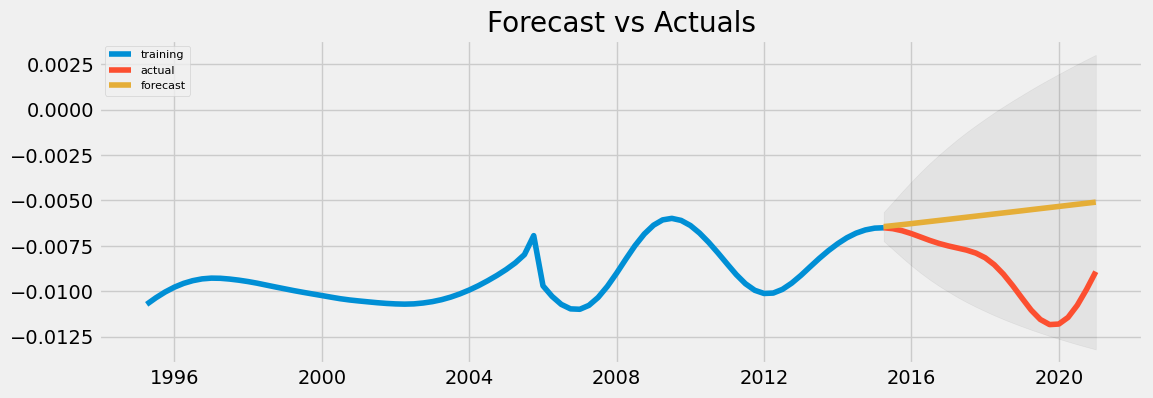

In [42]:
# We can assume that we chose too many AR and MA terms, so let's start by reducing them to see how it affects the forecast

model = ARIMA(train, order=(3, 1, 1))  
fitted = model.fit()  
print(fitted.summary())

# Forecast
fc, se, conf = fitted.forecast(24, alpha=0.05)  # 95% conf

# Make into pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,4), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.05)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

Success! While the yellow line still doesn't completely overlap the red line, they're both within the confidence interval, meaning they're not significantly different.